In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
import os
import yaml
import pickle
from datetime import datetime

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [4]:
from grid.policy import get_state, next_state, get_cell_i, get_cell_j
from grid.policy import get_policy, get_ratio, sample_policy, policy_noising, support, policy_data
from grid.policy import occupation_measure, occupation_measure_sanity
from grid.utils import sample_standard_simplex, generate_id
from grid.params import transition_probability_matrix, discounted_probability_matrix, expected_reward_vector, expected_risk_vector
from grid.optimize import optimal_policy
from grid.plotting import plot_policy, plot_occupation_measure, plot_reward, plot_ratio

In [ ]:
configs_file = 'configs.yaml'

with open(configs_file,'r') as handle:
    try:
        configs = yaml.safe_load(handle)
    except yaml.YAMLError as e:
        print('({}) ERROR ... Could not load configs yaml.'.format('root'))
        raise e

# Notebook Sections

* * *

(1) Grid world.<br>
(2) Hyper-parameters.<br>
(3) Transition probabilities.<br>
(4) Reward.<br>
(5) Risk.<br>
(6) Sample policy.<br>
(7) Optimal policy.<br>
(8) Policy test.<br>
(9) Policy noising.<br>
(10) Policy data.<br>
(11) Policy extraction.<br>

* * *

## Grid World

* * *

Consider an $m \times n$ grid. Each tile of the grid constitutes a state. 

$$ \begin{array}{|c|c|c|}
\hline (0,0) & \cdots & (0,n-1) \\ \hline
\hline &  &  \\ \hline 
\hline (m-1,0) & \cdots & (m-1,n-1) \\
\hline
\end{array} $$

Actions are $\mathcal{A} = \{U,D,L,R,N\}$ correspond to moving *up*, *down*, *left*, *right*, or *none* for staying put. 

When possible, we move with probability $1-\delta$ under action $a=U,D,L,R$. There is a small transition probability $\delta$ to one of the other states.

The goal is to reach a pre-determined terminal cell.

* * *

## Hyper-parameters

* <u>User-defined hyper-params</u>: grid dimensions, $\delta$, discount, number of obstacles, time horizon, etc.
* <u>Fixed</u>: derived hyper-params.
* <u>Sampled hyper-params</u>: allow variability in the grid-world problem w.r.t. the obstacles, initial state distribution, initial state.

### * User-defined

Grid dimensions.

In [5]:
m, n = 4, 5

Probability for random state under actions U / D / L / R.

In [6]:
delta = 0.05

Discount factor.

In [7]:
discount = 0.9

Number of obstacles in grid.

In [8]:
obstacle_num = 2

Time horizon: number of data points in policy dataset.

In [9]:
T = 1000

Noise added to optimal policy to generate data. Noise level in $[0,1]$, with $1$ giving rise to a completely random (non-deterministic) policy.

In [10]:
noise = 0.05

Noise added to expected reward / risk vectors.

In [11]:
epsilon = 0.01

Tolerance for near-zero results.

In [12]:
tol = 1e-6

Directory to store generated data pickle.

In [13]:
root = configs['local']['buckets']['data']

### * Fixed

In [14]:
actions = ['U','D','L','R','N']

In [15]:
states = [*range(m*n)]

In [16]:
state_num = len(states)
action_num = len(actions)

In [17]:
atol = abs(int(np.log10(tol)))-2

Terminal cell.

In [18]:
final = get_state(m-1,n-1,m,n)
states_wo_final = list(set(states) - set([final]))

### * Sampled

Sampled obstacle cells.

In [19]:
obstacles = next_state(states_wo_final,size=obstacle_num)

In [20]:
obstacles

array([12,  3])

Sampled initial state distribution.

In [21]:
state_dist = sample_standard_simplex(m*n)

Sampled initial cell.

In [22]:
init_state = next_state(states,state_dist)[0]

## Transition Probabilities

For $a \in \mathcal{A}$, the transition matrix $P(a) \in {M}_{\vert \mathcal{S} \vert \times \lvert \mathcal{S} \rvert}(\mathbb{R})$ is defined as
$$\begin{align*}
    & P(a)_{s',s} = \Pr[s' \vert s,a]
\end{align*}$$

i.e., the probability of transitioning from state $s$ to state $s'$ under action $a$. 

In [23]:
P = transition_probability_matrix(m,n,delta,tol=tol)

## Reward

Consider $c \in \mathbb{R}^{\vert S \vert}$ and define the expected reward vector $r \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ to be

$$\begin{align*}
    & r(s,a) = \sum_{s' \in \mathcal{S}} c_{s'} P(a)_{s',s} 
\end{align*}$$

Pick some grid state $s_f$ as the final destination. Let $c_{s_f} = 0$ and $c_{s} = -1$ for $s \neq s_f$. Maximizing the reward would then imply reaching the destination by the shortest route. 

We can add a set of obstacles $\mathcal{S}_O \subseteq \mathcal{S}$ to the grid by setting $c_s = M \ll -1$ for $s \in \mathcal{S}_O$.

In __[Chow et al, NIPS '15](https://proceedings.neurips.cc/paper/2015/hash/64223ccf70bbb65a3a4aceac37e21016-Abstract.html)__ one has $M = {2}/{(1-\gamma)}$ for the discount factor $\gamma$.


We will add some jitter to the reward vector to ensure non-degeneracy.

In [24]:
r = -expected_reward_vector(m,n,discount,final,obstacles,P,epsilon=epsilon)

## Risk

We'll define a risk vector $d \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ weighed against moving along the upper or lower edges of the grid (this will ensure no cell is degenerate).

We will also add a bit of additional risk for either doing nothing or walking into the boundary.

There is a non-zero lower bound on risk to avoid "exploding" ratio for epsilon risks.

We will add some jitter to the reward vector to ensure non-degeneracy.

In [25]:
d = -expected_risk_vector(m,n,epsilon=epsilon)

## Sample Policy

A policy $\pi: \mathcal{S} \rightarrow \Delta_{\mathcal{A}}$ is a map from states to distributions over $\mathcal{A}$.

In [26]:
p = sample_policy(states,actions,is_deterministic=False,beta=0.1)

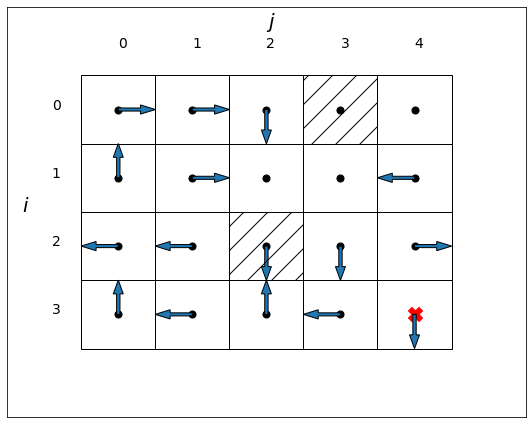

In [27]:
plot_policy(p,states,actions,m,n,final,obstacles=obstacles)

## Optimal Policy

The optimal policy for EMRDP, phrased in terms of the occupancy measure $\rho^\pi \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ of $\pi$, is formulated for this problem as

$$\min_{\pi} \bigg\{ \frac{r^T \rho^\pi}{d^T \rho^\pi} \,\bigg| \, Q\rho^\pi=\mu, \rho^\pi \geq 0 \bigg\} $$

In the discounted model, 
$$\begin{align*}
    Q = \bigg[ I-\gamma P(a_1) \, \bigg| \,\cdots\, \bigg|\, I - \gamma P(a_k) \bigg] , \quad
\end{align*}$$

for $\mathcal{A} = \{a_1,\ldots,a_k\}$, some initial state distribution $\mu$, and discount factor $\gamma$.

In [28]:
Q = discounted_probability_matrix(m,n,discount,delta,tol=tol)

The row vector $(1,\ldots,1) \in \mathbb{R}^{\vert \mathcal{S} \vert}$ is an eigenvector of $Q$ for the  eigenvalue $(1-\gamma)$.

In [29]:
np.ones((1,Q.shape[0])) @ Q / (1-discount)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]])

Algorithm for finding the true optimal policy.

In [30]:
rhos, rewards, risks, success = optimal_policy(states,actions,Q,r,d,state_dist,discount,tol)

--------------------------------------
Switch action at: (s,a) = (14,D)
Next risk: -5.008, Next reward: -1.274
--------------------------------------
--------------------------------------
Switch action at: (s,a) = (13,R)
Next risk: -5.005, Next reward: -1.214
--------------------------------------
--------------------------------------
Switch action at: (s,a) = (9,D)
Next risk: -5.000, Next reward: -1.088
--------------------------------------
--------------------------------------
Switch action at: (s,a) = (6,R)
Next risk: -4.994, Next reward: -0.959
--------------------------------------
--------------------------------------
Switch action at: (s,a) = (17,N)
Next risk: -4.988, Next reward: -0.852
--------------------------------------
--------------------------------------
Switch action at: (s,a) = (17,R)
Next risk: -4.981, Next reward: -0.838
--------------------------------------
--------------------------------------
Switch action at: (s,a) = (8,D)
Next risk: -4.980, Next reward:

In [31]:
print('Policy optimization successful: {}'.format(success))

Policy optimization successful: True


In [32]:
# sanity check: all rhos are occupation measures

A = np.vstack([Q,d.T])

for rho in rhos:
    occupation_measure_sanity(rho,A,state_dist,discount,tol*100)

Plot algorithm results for finding the true optimal policy.

In [33]:
for i, (re, ri) in enumerate(zip(rewards, risks)):
    print('Iteration {}: reward {:.3f}, risk {:.3f}, ratio: {:.3f}'.format(i,(re),ri,(re)/(ri)))

Iteration 0: reward -1.327, risk -5.010, ratio: 0.265
Iteration 1: reward -1.274, risk -5.008, ratio: 0.254
Iteration 2: reward -1.214, risk -5.005, ratio: 0.243
Iteration 3: reward -1.088, risk -5.000, ratio: 0.218
Iteration 4: reward -0.959, risk -4.994, ratio: 0.192
Iteration 5: reward -0.852, risk -4.988, ratio: 0.171
Iteration 6: reward -0.838, risk -4.981, ratio: 0.168
Iteration 7: reward -0.837, risk -4.980, ratio: 0.168
Iteration 8: reward -0.517, risk -4.339, ratio: 0.119
Iteration 9: reward -0.506, risk -4.305, ratio: 0.118
Iteration 10: reward -0.497, risk -4.259, ratio: 0.117
Iteration 11: reward -0.490, risk -4.210, ratio: 0.116
Iteration 12: reward -0.481, risk -4.139, ratio: 0.116
Iteration 13: reward -0.477, risk -4.106, ratio: 0.116
Iteration 14: reward -0.477, risk -4.094, ratio: 0.117
Iteration 15: reward -0.477, risk -4.077, ratio: 0.117
Iteration 16: reward -0.477, risk -4.063, ratio: 0.117


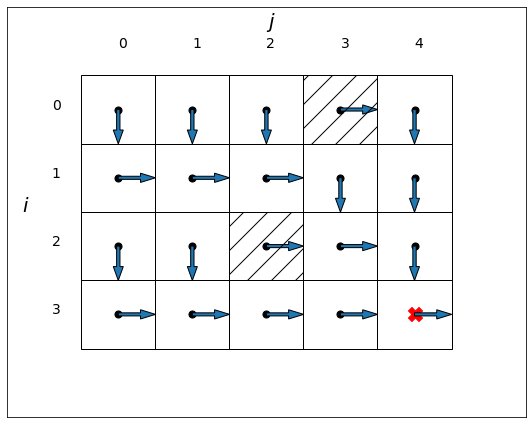

In [34]:
i = -1

p = get_policy(np.around(rhos[i],atol), states, actions)

plot_policy(p,states,actions,m,n,final,obstacles=obstacles)

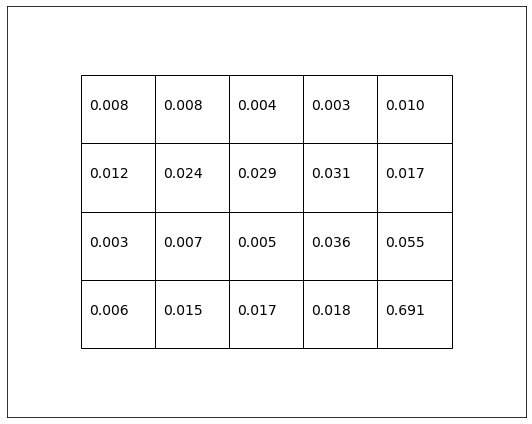

In [35]:
plot_occupation_measure(rhos[-1],states,actions,m,n,tol=tol)

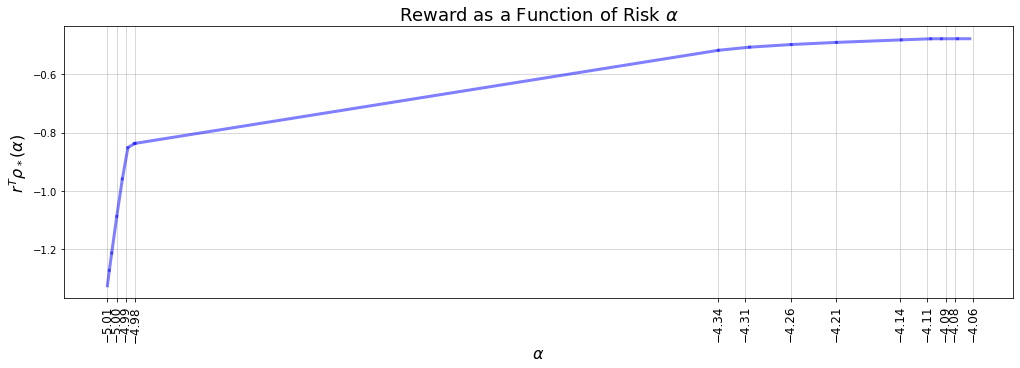

In [36]:
plot_reward(risks, rewards, atol=2, figsize=(17,5))

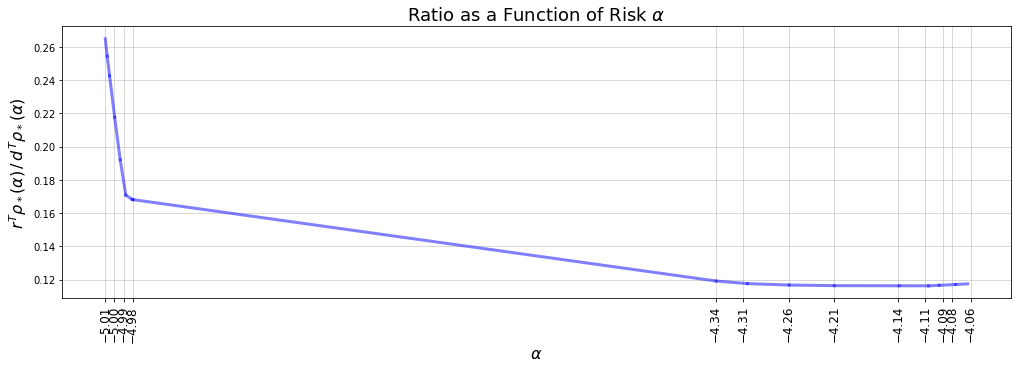

In [37]:
plot_ratio(risks, rewards, atol=2, figsize=(17,5))

## Policy Noising

Add noise to the optimal policy.

In [38]:
p_opt = get_policy(np.around(rhos[-1],atol), states, actions)

In [39]:
p_opt_noise = policy_noising(p_opt, noise, states, actions, state_dist, discount, P)

## Policy Data

Generate tabular data from the noised optimal policy.

Policy data, as well as all other data necessary for reproducibility, will be pickled.

In [40]:
policy_data_id = generate_id()
now = datetime.now().strftime('%Y-%m-%d-%H%M')

In [41]:
df = policy_data(p_opt_noise,init_state,T,states,actions,m,n,P,r,d)

In [42]:
data = {
    'm': m,
    'n': n,
    'final': final,
    'obstacles': obstacles,
    'init_state': init_state,
    'state_dist': state_dist,
    'discount': discount,
    'delta': delta,
    'tol': tol,
    'noise': noise,
    'epsilon': epsilon,
    'P': P,
    'r': r,
    'd': d,
    'p_data': p_opt_noise,
    'p_opt': p_opt,
    'pareto_rewards': rewards,
    'pareto_risks': risks,
    'pareto_rhos': rhos,
    'df': df,
    'policy_data_id': policy_data_id,
    'timestamp': now
}

In [43]:
p_file = 'grid_world_data_{}.pickle'.format(policy_data_id)
p_path = os.path.join(root,p_file)

with open(p_path, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
with open(p_path, 'rb') as handle:
    data = pickle.load(handle)

data['df'].head()

,state_i,state_j,action,reward,risk
0,2,1,1,-1.189985,-4.999219
1,3,1,3,-1.198804,-1.005982
2,3,2,3,-1.200948,-1.016239
3,3,3,3,-0.256871,-1.025210
4,3,4,3,-0.255924,-3.986113


## Test

Test a policy (manually defined) when the grid is of dimensions **3x3** and there are **no obstacles**.

In [45]:
if m==3 and n==3:
    
    p_test = {0: np.array([0., 1., 0., 0., 0.]),
              1: np.array([0., 1., 0., 0., 0.]),
              2: np.array([0., 1., 0., 0., 0.]),
              3: np.array([0., 0., 0., 1., 0.]),
              4: np.array([0., 0., 0., 1., 0.]),
              5: np.array([0., 1., 0., 0., 0.]),
              6: np.array([1., 0., 0., 0., 0.]),
              7: np.array([1., 0., 0., 0., 0.]),
              8: np.array([0., 1., 0., 0., 0.])}

In [46]:
if m==3 and n==3:

    rho_test = occupation_measure(p_test,state_dist,discount,P,tol)
    occupation_measure_sanity(rho_test,A,state_dist,discount,tol*10)

In [47]:
if m==3 and n==3:

    reward_test, risk_test, ratio_test = get_ratio(rho_test, r, d)

    print('Test Reward: {:3f}\nTest Risk: {:3f}\nTest Ratio: {:3f}'.format(reward_test,risk_test,ratio_test))

In [48]:
if m==3 and n==3:

    plot_policy(p_test,states,actions,m,n,final,obstacles=obstacles)

In [49]:
if m==3 and n==3:

    plot_occupation_measure(rho_test,states,actions,m,n)

In [50]:
if m==3 and n==3:

    p_test_retrieve = get_policy(rho_test,states,actions)
    retrieved = all([np.all(np.isclose(p_test[s],p_test_retrieve[s],atol=tol)) for s in states])
    print('(Sanity Check) Test policy retrieved: {}'.format(retrieved))